https://colab.research.google.com/drive/17IF4Iur2A-PrFpaL4_cJGTwFIGY-CUY2?usp=sharing

# Building a Neural Network to Predict Japanese Hiragana Characters

We use PyTorch to build the neural network.
Data we use is downloaded below.

In [1]:
# Libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim   # SGD
import time

## The Kuzushiji MNIST data

The Kuzushiji-MNIST data set consists of 70,000 28x28 grayscale images spanning 10 classes of Japanese hiragana characters.

100%|██████████| 18165135/18165135 [00:48<00:00, 376072.12it/s] 


Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 83182.43it/s]


Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:11<00:00, 265130.62it/s]


Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 9864417.31it/s]


Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw



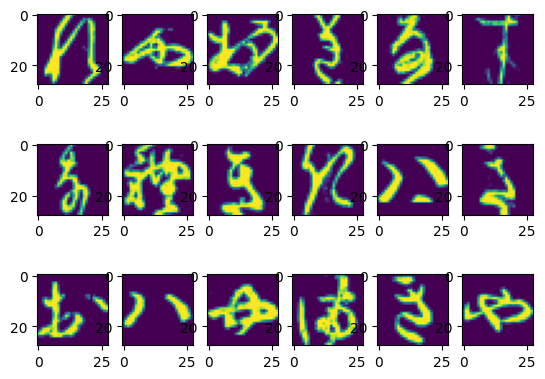

In [4]:
# Download KuzushijiMNIST training data and view some of its images
kuzushiji_images = datasets.KMNIST('data', train=True, download=True)

for k, (image, label) in enumerate(kuzushiji_images):
    if k >= 18:
        break
    plt.subplot(3, 6, k+1)
    plt.imshow(image)

In [2]:
# Download KuzushijiMNIST and convert to tensor for training
kuzushiji_data = datasets.KMNIST('data', train = True,
                                   transform = transforms.ToTensor())
kuzushiji_data = list(kuzushiji_data)

# Set 80% as training and 20% as validation set
train_size = int(len(kuzushiji_data)*0.8)
val_size = int(len(kuzushiji_data)*0.2)

# Use the random_split function to create training and validation sets
kuzushiji_train, kuzushiji_val = torch.utils.data.random_split(
    kuzushiji_data, [train_size, val_size])

# Check no. obs in train and validation sets
len(kuzushiji_train), len(kuzushiji_val)

(48000, 12000)

## Building the Model

### Model Architecture and Layers 

In [3]:
# NN with dropout
dropout = 0.5 # probability of dropping out a unit

num_L1_out = 512 #1024
num_L2_out= 512
num_L3_out = 512
num_output = 10

model = nn.Sequential(nn.Flatten(),
                      nn.Linear(28*28, num_L1_out),
                      nn.BatchNorm1d(num_L1_out), # note that at prediction time, mean and variance
                      # are estimated using the entire training dataset and remain fixed. 
                      nn.ReLU(),
                      # Add a dropout layer after the first fully connected layer
                      nn.Dropout(dropout), # Dropout is applied only at training time.
                      nn.Linear(num_L1_out,num_L2_out),
                      nn.BatchNorm1d(num_L2_out),
                      nn.ReLU(),
                      # Add a dropout layer after the 2nd fully connected layer
                      nn.Dropout(dropout),
                      nn.Linear(num_L2_out, num_L3_out),
                      nn.BatchNorm1d(num_L3_out),
                      nn.ReLU(),
                      # Add a dropout layer after the 3rd fully connected layer
                      nn.Dropout(dropout),
                      nn.Linear(num_L3_out,num_output))

### Parameter Initialization
We use Xavier and He initialization.

In [102]:
# The function to initialize the parameters
def init_weights(m):
    "Initialise weights to the linear layer"
    if type(m) == nn.Linear:
        #nn.init.normal_(tensor=m.weight, mean=0.0,std=0.01) # initializing from normal distribution
        nn.init.xavier_normal_(tensor=m.weight) # Xavier and He initialization
        m.bias.data.fill_(0.01) # initializing bias to 0.01

model.apply(init_weights);

In [103]:
print(model.parameters)

<bound method Module.parameters of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=512, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=512, out_features=512, bias=True)
  (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=512, out_features=10, bias=True)
)>


### Set up the device and transfer the model

In [104]:
# Check if GPU is available. The program will run using the GPU if available, otherwise will use CPU.
cuda = torch.cuda.is_available()
cuda #returns a Boolean indicating availability of GPU

# SET device = gpu IF gpu available ELSE use cpu
device = torch.device("cuda" if cuda else "cpu")

# Transfer model to device.
model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=512, out_features=512, bias=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=512, out_features=512, bias=True)
  (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=512, out_features=10, bias=True)
)


## Training Setup

### Training function
The main training function to call when training the model. It will output plots, as well as validation accuracy.

In [105]:
def train(model, data, batch_size=64, num_epochs=1, learning_rate = 0.01):
    """
    For num_epoch of times, iterate over the mini-batches and
    and update the parameters at each iteration.
    At the start of each epoch the data is shuffled and a new set of
    mini-batch
    """

    # The training data is split into mini-batches of size batch_size.
    train_loader = torch.utils.data.DataLoader(data, batch_size = batch_size,
                                        shuffle = True) # shuffle the data.

    # Set Criterion to the approriate loss function
    criterion = nn.CrossEntropyLoss()

    # Set the optimizer
    #optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.1) 
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0) # Adam optimizer
    
    # Store evaluation metrics
    iters, losses, train_acc, val_acc = [], [], [], []

    # Training loop
    n = 0 # the number of iterations
    start_time = time.time()

    for epoch in range(num_epochs):

        #Iterate over the mini-batches
        for imgs, labels in iter(train_loader):

            model.train() # put model to training mode (needed for dropout and batchnorm)
            
            running_loss = 0.0

            # Transfer data to device
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Forward pass: outputs logits for each image(imgs) and computes the CE loss
            out = model(imgs)
            loss = criterion(out, labels) # CE loss for the current minibatch
            running_loss += loss.item() # record sum of losses over mini-batches

            # Backward pass and update
            loss.backward() # backprop
         #   nn.utils.clip_grad_norm_(model.parameters(), 1.0) # gradient clipping
            optimizer.step() # update parameters
            optimizer.zero_grad() # reset gradient

            # Save the current training information to report
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1
        # End of an epoch
        end_time = time.time()
        running_loss /= len(train_loader)
        print(f'Training Loss in epoch {epoch+1}/{num_epochs}: {round(losses[-1],5)}, Time: {round(end_time - start_time,5)}s')

    # Plot results after training is done.

    # Plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Accuracy Function

To turn the probabilities into a discrete prediction, we will take the digit with the highest probability. 
Note: Because of the way softmax is computed, the digit with the highest probability is the same as the digit with the (pre-activation) output value.

In [106]:
train_acc_loader = torch.utils.data.DataLoader(kuzushiji_train, batch_size=len(kuzushiji_train), shuffle=True)
val_acc_loader = torch.utils.data.DataLoader(kuzushiji_val, batch_size=len(kuzushiji_val), shuffle=False) # we don't shuffle validation data


def get_accuracy(model, train=False):
    """
    - Computes the accuracy of the training data (train=True), and validation
    data (train=False). 
    - Accuracy is defined as (number of correct predictions)/(total
    number of predictions).
    - This function is called from inside the training loop.
    - Returns accuracy, a scalar value.
    """
    if train:
        data = kuzushiji_train
    else:
        data = kuzushiji_val

    model.eval() # set model to evaluation mode (needed for dropout and batchnorm)

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        # Transfer data to device
        imgs = imgs.to(device)
        labels = labels.to(device)

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# Training the neural network on the full training set

Note that even though we didn't include it in the final output, we first ran the model on a subset of our data to debug our code.

Training Loss in epoch 1/10: 0.00024, Time: 27.22021s
Training Loss in epoch 2/10: 0.00016, Time: 53.98928s
Training Loss in epoch 3/10: 0.00016, Time: 80.89017s
Training Loss in epoch 4/10: 0.00013, Time: 108.70224s
Training Loss in epoch 5/10: 9e-05, Time: 134.75308s
Training Loss in epoch 6/10: 0.00012, Time: 159.60658s
Training Loss in epoch 7/10: 9e-05, Time: 184.49954s
Training Loss in epoch 8/10: 0.00011, Time: 208.94377s
Training Loss in epoch 9/10: 7e-05, Time: 233.63183s
Training Loss in epoch 10/10: 6e-05, Time: 469.00316s


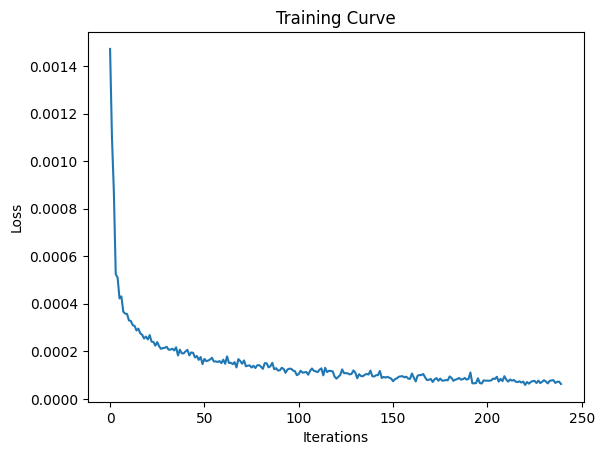

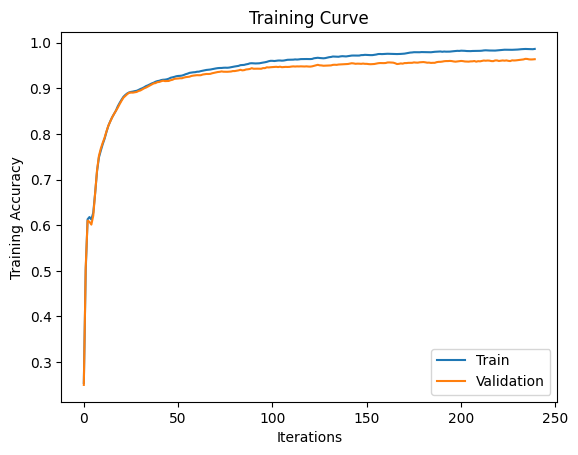

Final Training Accuracy: 0.9862708333333333
Final Validation Accuracy: 0.96375


In [107]:
train(model, kuzushiji_train, batch_size = 2048, num_epochs=10)

# Exploration: Relationship Between Batch Size and Learning Rate
Please uncomment the lines to run. Note that it takes more than 10 minutes to run all of the combinations. 

In [112]:
size = [600, 1200, 2400]
rate = [0.01, 0.04, 0.1]

"""for s in size:
    for r in rate:
        train(model, kuzushiji_train, batch_size = s, num_epochs=5, learning_rate=r)"""

'for s in size:\n    for r in rate:\n        train(model, kuzushiji_train, batch_size = s, num_epochs=5, learning_rate=r)'

# MLP with one hidden layer

### Model Architecture and Layers 
Note that the model is now called "model_onelayer"

In [10]:
# NN with dropout
dropout = 0.5 # probability of dropping out a unit

num_L1_out = 512
num_output = 10

model_onelayer = nn.Sequential(
                     nn.Flatten(),
                     nn.Linear(28*28, num_L1_out),
                     nn.BatchNorm1d(num_L1_out), # note that at prediction time, mean and variance
                     # are estimated using the entire training dataset and remain fixed. 
                     nn.ReLU(),
                     # Add a dropout layer after the first fully connected layer
                     nn.Dropout(dropout), # Dropout is applied only at training time.
                     nn.Linear(num_L1_out, num_output)  # Output layer
                   )

### Parameter Initialization
We use Xavier and He initialization.

In [114]:
def init_weights(m):
    "Initialise weights to the linear layer"
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal(m.weight) # we use Xavier and He initialization
        m.bias.data.fill_(0.01) # initializing bias to 0.01
model_onelayer.apply(init_weights);

/var/folders/2p/zsvmljhd45n72ws61v37xglh0000gn/T/ipykernel_30097/3306672912.py:4: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(m.weight) # we use Xavier and He initialization


### Set up the device and transfer the one hidden layer model

In [115]:
# SET device = gpu IF gpu available ELSE use cpu
device = torch.device("cuda" if cuda else "cpu")

# Transfer model to device.
model_onelayer.to(device)
print(model_onelayer)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=512, out_features=10, bias=True)
)


### Training the neural network on the full training set

Training Loss in epoch 1/10: 0.00023, Time: 10.8059s
Training Loss in epoch 2/10: 0.00017, Time: 21.52823s
Training Loss in epoch 3/10: 0.00015, Time: 32.55206s
Training Loss in epoch 4/10: 0.00013, Time: 42.98852s
Training Loss in epoch 5/10: 0.00011, Time: 54.70405s
Training Loss in epoch 6/10: 9e-05, Time: 65.93356s
Training Loss in epoch 7/10: 8e-05, Time: 76.62794s
Training Loss in epoch 8/10: 0.00011, Time: 87.46072s
Training Loss in epoch 9/10: 8e-05, Time: 99.44101s
Training Loss in epoch 10/10: 6e-05, Time: 110.53121s


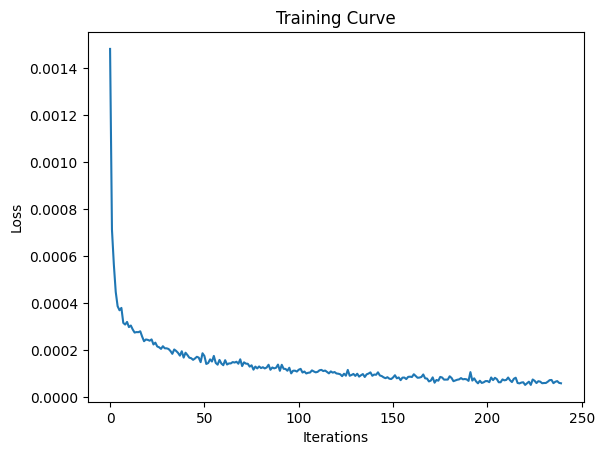

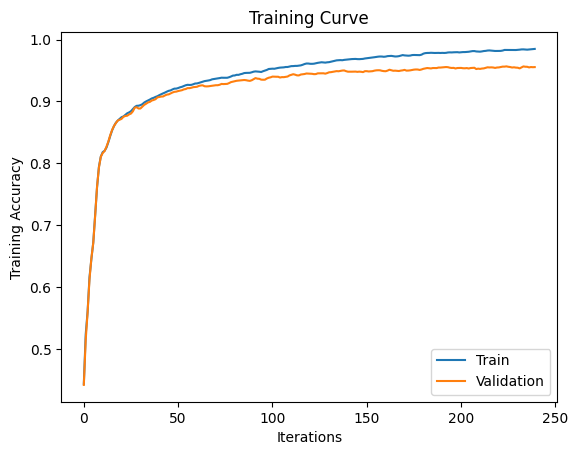

Final Training Accuracy: 0.9848333333333333
Final Validation Accuracy: 0.9555


In [116]:
train(model_onelayer, kuzushiji_train, batch_size=2048, num_epochs=10)